In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as IMBPipeline
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import AdaBoostClassifier

In [153]:
df = pd.read_csv('/Users/devyanshichandra/Downloads/features_3_sec.csv').drop(columns=['filename', 'length'])

# Extract feature names and store features in X
features = list(df.columns)[:-1]
X = df[features]

In [154]:
# labels = encoder.get_feature_names_out (['label']) >> new name depending on version
encoder = OneHotEncoder()
y = encoder.fit_transform(df[['label']]).toarray()
labels = encoder.get_feature_names_out(['label'])

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

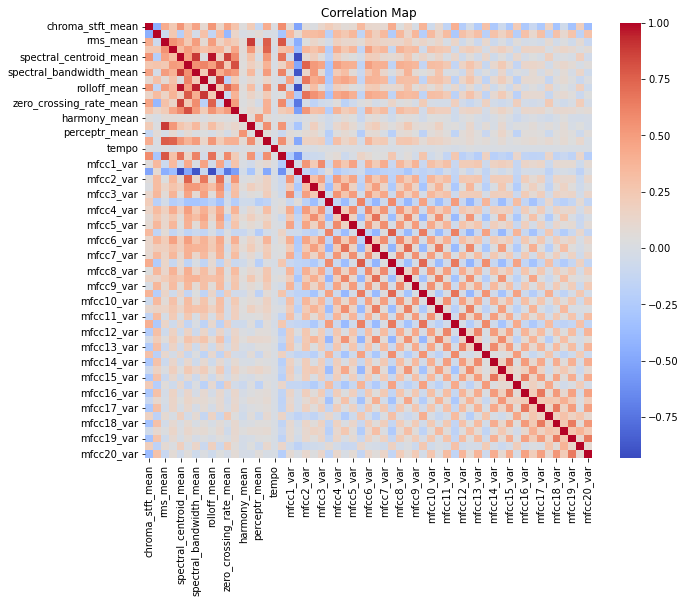

In [156]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Map')
plt.show()

In [157]:
xgb_base = xgb.XGBClassifier(objective='binary:logistic')
multilabel_model = MultiOutputClassifier(xgb_base)

multilabel_model.fit(X_train, y_train)
y_pred = multilabel_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7932932932932933


In [158]:
pca = PCA(n_components=0.95)
knn = KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1)

In [159]:
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE for oversampling
    ('pca', pca),
    ('knn', knn)
])

In [160]:
param_grid = {
    'knn__n_neighbors': [3, 5, 7],  # Reduced range for n_neighbors
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

In [161]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('pca', PCA(n_components=0.95)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='kd_tree',
                                                             n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': [3, 5, 7],
                         'knn__weights': ['uniform', 'distance']},
             verbose=1)

In [162]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [163]:
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88       208
           1       0.90      0.94      0.92       203
           2       0.87      0.78      0.83       186
           3       0.89      0.89      0.89       199
           4       0.95      0.89      0.92       218
           5       0.93      0.84      0.88       192
           6       0.98      0.96      0.97       204
           7       0.95      0.89      0.92       180
           8       0.88      0.92      0.90       211
           9       0.88      0.81      0.84       197

   micro avg       0.92      0.88      0.90      1998
   macro avg       0.92      0.88      0.90      1998
weighted avg       0.92      0.88      0.90      1998
 samples avg       0.92      0.88      0.88      1998



In [164]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}


In [165]:
optimized_pipeline = IMBPipeline([('smote', SMOTE(random_state=42)),  # Handle class imbalance
    ('pca', PCA(n_components=0.95)),    # Dimensionality reduction
    ('knn', KNeighborsClassifier(
        n_neighbors=3, 
        weights='distance', 
        metric='euclidean', 
        algorithm='kd_tree', 
        n_jobs=-1))                     # optimized KNN w/ best parameters
])

In [166]:
optimized_pipeline.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('pca', PCA(n_components=0.95)),
                ('knn',
                 KNeighborsClassifier(algorithm='kd_tree', metric='euclidean',
                                      n_jobs=-1, n_neighbors=3,
                                      weights='distance'))])

In [167]:
y_pred = optimized_pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.88       208
           1       0.90      0.94      0.92       203
           2       0.87      0.78      0.83       186
           3       0.89      0.89      0.89       199
           4       0.95      0.89      0.92       218
           5       0.93      0.84      0.88       192
           6       0.98      0.96      0.97       204
           7       0.95      0.89      0.92       180
           8       0.88      0.92      0.90       211
           9       0.88      0.81      0.84       197

   micro avg       0.92      0.88      0.90      1998
   macro avg       0.92      0.88      0.90      1998
weighted avg       0.92      0.88      0.90      1998
 samples avg       0.92      0.88      0.88      1998



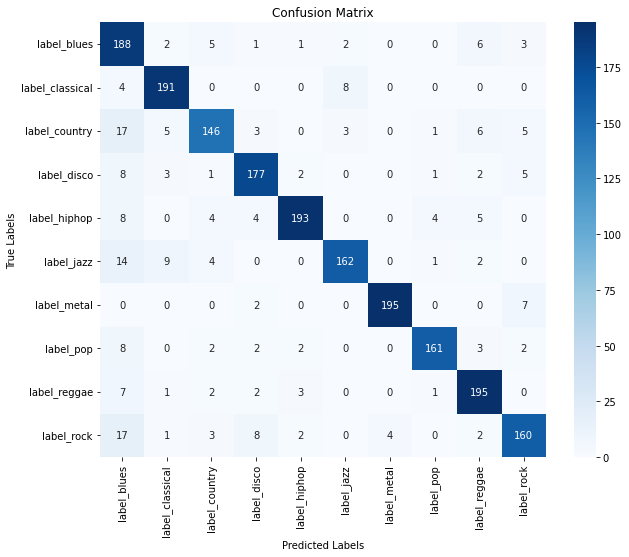

In [168]:
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [169]:
# svm implementation
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [170]:
clf = svm.SVC(kernel = 'linear', C=1)
clf.fit(X_train, y_train_labels)
predictions = clf.predict(X_test)

In [171]:
accuracy = accuracy_score(y_test_labels, predictions)
print('Accuracy for SVM: ', accuracy)

Accuracy for SVM:  0.7717717717717718


In [172]:
print(classification_report(y_test_labels, predictions))

              precision    recall  f1-score   support

           0       0.72      0.79      0.76       208
           1       0.90      0.95      0.93       203
           2       0.65      0.72      0.68       186
           3       0.68      0.70      0.69       199
           4       0.78      0.76      0.77       218
           5       0.85      0.85      0.85       192
           6       0.86      0.87      0.86       204
           7       0.83      0.88      0.85       180
           8       0.78      0.64      0.70       211
           9       0.65      0.55      0.60       197

    accuracy                           0.77      1998
   macro avg       0.77      0.77      0.77      1998
weighted avg       0.77      0.77      0.77      1998



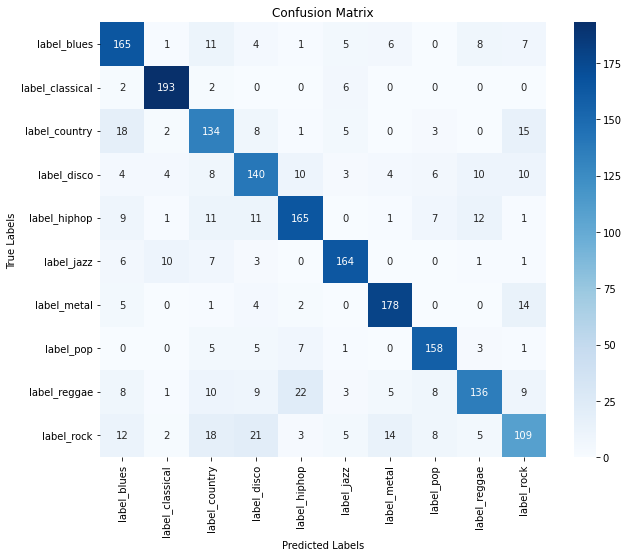

In [173]:
conf_matrix = confusion_matrix(y_test_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [179]:
xgb_probs = np.array(multilabel_model.predict_proba(X_test))
knn_probs = np.array(optimized_pipeline.predict_proba(X_test))

xgb_probs = np.array(xgb_probs)
knn_probs = np.array(knn_probs)

# Combine probabilities using simple averaging
ensemble_probs = (xgb_probs + knn_probs) / 2

In [180]:
threshold = 0.5
ensemble_binary_predictions = (ensemble_probs >= threshold).astype(int)

# Ensure binary predictions have the correct shape
ensemble_binary_predictions = ensemble_binary_predictions[:, :, 1]  # Assuming you're interested in class 1 predictions

# Convert binary predictions to class labels
ensemble_majority_predictions = np.mean(ensemble_binary_predictions, axis=0)
ensemble_majority_predictions = (ensemble_majority_predictions >= 0.5).astype(int)

# Calculate the accuracy score
ensemble_accuracy = accuracy_score(y_test_labels, ensemble_majority_predictions)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.1041041041041041


In [176]:
print("Shape of XGBoost probabilities:", xgb_probs.shape)
print("Shape of KNN probabilities:", knn_probs.shape)

# Check if probabilities are within the valid range
print("Minimum probability:", np.min(ensemble_probs))
print("Maximum probability:", np.max(ensemble_probs))

Shape of XGBoost probabilities: (10, 1998, 2)
Shape of KNN probabilities: (10, 1998, 2)
Minimum probability: 3.984926877365069e-08
Maximum probability: 0.9999999701976776


In [177]:
# Ensure consistent data formats
print("Shape of X_test:", X_test.shape)
print("Shape of y_test_labels:", y_test_labels.shape)

# Verify binary predictions
print("Shape of ensemble_binary_predictions:", ensemble_binary_predictions.shape)

# Check probability ranges
print("Minimum probability:", np.min(ensemble_probs))
print("Maximum probability:", np.max(ensemble_probs))

# Threshold probabilities to obtain binary predictions
threshold = 0.5
ensemble_binary_predictions = (ensemble_probs >= threshold).astype(int)

# Verify binary predictions after thresholding
print("Shape of thresholded ensemble_binary_predictions:", ensemble_binary_predictions.shape)

# Convert binary predictions to class labels
ensemble_majority_predictions = np.argmax(np.mean(ensemble_binary_predictions, axis=0), axis=1)

# Calculate the accuracy score
ensemble_accuracy = accuracy_score(y_test_labels, ensemble_majority_predictions)
print("Ensemble Accuracy:", ensemble_accuracy)

Shape of X_test: (1998, 57)
Shape of y_test_labels: (1998,)
Shape of ensemble_binary_predictions: (10, 1998, 2)
Minimum probability: 3.984926877365069e-08
Maximum probability: 0.9999999701976776
Shape of thresholded ensemble_binary_predictions: (10, 1998, 2)
Ensemble Accuracy: 0.1041041041041041


In [181]:
print("Shape of ensemble_majority_predictions:", ensemble_majority_predictions.shape)
print("Shape of y_test_labels:", y_test_labels.shape)

# Print the first few elements of ensemble_majority_predictions and y_test_labels
print("First few elements of ensemble_majority_predictions:", ensemble_majority_predictions[:10])
print("First few elements of y_test_labels:", y_test_labels[:10])

Shape of ensemble_majority_predictions: (1998,)
Shape of y_test_labels: (1998,)
First few elements of ensemble_majority_predictions: [0 0 0 0 0 0 0 0 0 0]
First few elements of y_test_labels: [4 5 0 0 6 9 7 2 2 0]
